In [1]:
import sys
sys.path.append('../')
import torch
import torch.nn as nn
from data_process import get_data_loaders, getFeatures
from model.TCN import TemporalConvNet, TCN
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
input_len, output_len = 20, 10 

In [4]:
data = pd.read_csv('../flights.csv') 
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']
data, train_loader, val_loader, test_loader, d_split = get_data_loaders(data, input_len, output_len, test_size=0.2, val_size=0.2, 
                                                                        features=select_features, covariates=False)
# features = getFeatures()

In [5]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 20, 7])
torch.Size([64, 10])


In [6]:
# build TCN-LSTM model

class Encoder(nn.Module):
    def __init__(self, input_size, seq_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2):
        super(Encoder, self).__init__()
        self.tcn = TemporalConvNet(input_size, tcn_num_channels, tcn_kernel_size, tcn_dropout)
        self.fc_feature = nn.Linear(tcn_num_channels[-1], lstm_num_hidden)
        
        self.lstm_num_hidden = lstm_num_hidden
    
    def forward(self, x):
        output = self.tcn(x.transpose(1, 2)) # (batch_size, tcn_num_channels[-1], seq_len)
        output = output.transpose(1, 2) # (batch_size, seq_len, tcn_num_channels[-1])
        output = self.fc_feature(output) # (batch_size, seq_len, lstm_num_hidden)

        h = output[:, -1, :] # (batch_size, lstm_num_hidden)s
        c = output.mean(dim=1) # (batch_size, lstm_num_hidden)
        return h, c


class Decoder(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size, num_layers=1):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)
        self.num_layers = num_layers
        self.seq_len = seq_len

    def forward(self, x, hidden, cell):
        # repeat the hidden states according to the number of layers
        hidden = hidden.repeat(self.num_layers, 1, 1)
        cell = cell.repeat(self.num_layers, 1, 1)
        outputs = []
        for _ in range(self.seq_len): 
            output, (hidden, cell) = self.lstm(x, (hidden, cell))
            output = self.fc(output) 
            outputs.append(output[:, :, -1].unsqueeze(2))
            x = output

        outputs = torch.cat(outputs, dim=1)
        return outputs


class TCN_LSTM(nn.Module):
    def __init__(self, input_size, input_len, output_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2, num_layers=1):
        super(TCN_LSTM, self).__init__()
        self.encoder = Encoder(input_size, input_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size, tcn_dropout)
        self.decoder = Decoder(input_size, output_len, lstm_num_hidden, num_layers)

    def forward(self, x):
        # x: (batch_size, input_len, input_size)
        h, c = self.encoder(x)
        xt = x[:, -1, :].unsqueeze(1) # input the last time step of x into the decoder
        outputs = self.decoder(xt, h, c) # (batch_size, output_len, 1)
        return outputs

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

input_size = len(select_features)
hidden_size = 32  
num_layers = 1


# encoder = Encoder(input_size, input_len, [64,64,64], hidden_size)
# decoder = Decoder(hidden_size, output_len, hidden_size, num_layers=num_layers)
seq2seq = TCN_LSTM(input_size, input_len, output_len, [32, 32], hidden_size, num_layers=num_layers).to(device)

cuda


In [8]:
# train the model
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.002)

# Training loop with validation and early stopping
num_epochs = 25
best_epoch = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    seq2seq.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.6f}")

    # Validation phase
    seq2seq.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        with torch.no_grad():
            outputs = seq2seq(inputs)  
            outputs = outputs.squeeze(-1) # (batch_size, output_len)
            loss = criterion(outputs, targets)

        total_val_loss += loss.item()
        progress_bar.set_postfix({'val_loss': loss.item()})
    
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.6f}")

    # Save the model with least validation loss
    if average_val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = average_val_loss
        torch.save(seq2seq.state_dict(), f'TCN_LSTM_select3_best_model_{input_len}-{output_len}.pt')


Epoch 1/25 [TRAIN]: 100%|██████████| 2296/2296 [00:30<00:00, 74.50it/s, train_loss=0.00199]


Epoch 1/25, Average Training Loss: 0.006312


Epoch 1/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 125.03it/s, val_loss=0.00458]


Epoch 1/25, Average Validation Loss: 0.004177


Epoch 2/25 [TRAIN]: 100%|██████████| 2296/2296 [00:26<00:00, 85.81it/s, train_loss=0.0598] 


Epoch 2/25, Average Training Loss: 0.004181


Epoch 2/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 121.65it/s, val_loss=0.0044] 


Epoch 2/25, Average Validation Loss: 0.004137


Epoch 3/25 [TRAIN]: 100%|██████████| 2296/2296 [00:26<00:00, 86.02it/s, train_loss=0.000218]


Epoch 3/25, Average Training Loss: 0.003926


Epoch 3/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 124.70it/s, val_loss=0.00484]


Epoch 3/25, Average Validation Loss: 0.003660


Epoch 4/25 [TRAIN]: 100%|██████████| 2296/2296 [00:26<00:00, 86.18it/s, train_loss=0.00471]


Epoch 4/25, Average Training Loss: 0.003821


Epoch 4/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 124.46it/s, val_loss=0.00447]


Epoch 4/25, Average Validation Loss: 0.004106


Epoch 5/25 [TRAIN]: 100%|██████████| 2296/2296 [00:26<00:00, 85.96it/s, train_loss=0.000658]


Epoch 5/25, Average Training Loss: 0.003700


Epoch 5/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 123.49it/s, val_loss=0.00485]


Epoch 5/25, Average Validation Loss: 0.003572


Epoch 6/25 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 82.19it/s, train_loss=4.95e-6]


Epoch 6/25, Average Training Loss: 0.003648


Epoch 6/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 114.79it/s, val_loss=0.00511]


Epoch 6/25, Average Validation Loss: 0.003590


Epoch 7/25 [TRAIN]: 100%|██████████| 2296/2296 [00:29<00:00, 78.43it/s, train_loss=3.96e-5]


Epoch 7/25, Average Training Loss: 0.003522


Epoch 7/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 105.98it/s, val_loss=0.00446]


Epoch 7/25, Average Validation Loss: 0.003491


Epoch 8/25 [TRAIN]: 100%|██████████| 2296/2296 [00:31<00:00, 74.03it/s, train_loss=0.00482]


Epoch 8/25, Average Training Loss: 0.003428


Epoch 8/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 98.15it/s, val_loss=0.00415] 


Epoch 8/25, Average Validation Loss: 0.003392


Epoch 9/25 [TRAIN]: 100%|██████████| 2296/2296 [00:33<00:00, 67.54it/s, train_loss=0.00291]


Epoch 9/25, Average Training Loss: 0.003349


Epoch 9/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 100.23it/s, val_loss=0.00466]


Epoch 9/25, Average Validation Loss: 0.003197


Epoch 10/25 [TRAIN]: 100%|██████████| 2296/2296 [00:36<00:00, 63.08it/s, train_loss=0.00412]


Epoch 10/25, Average Training Loss: 0.003282


Epoch 10/25 [VAL]: 100%|██████████| 769/769 [00:08<00:00, 94.94it/s, val_loss=0.00399] 


Epoch 10/25, Average Validation Loss: 0.003264


Epoch 11/25 [TRAIN]: 100%|██████████| 2296/2296 [00:35<00:00, 65.12it/s, train_loss=0.0123] 


Epoch 11/25, Average Training Loss: 0.003254


Epoch 11/25 [VAL]: 100%|██████████| 769/769 [00:08<00:00, 88.20it/s, val_loss=0.00444] 


Epoch 11/25, Average Validation Loss: 0.003113


Epoch 12/25 [TRAIN]: 100%|██████████| 2296/2296 [00:35<00:00, 64.74it/s, train_loss=0.000924]


Epoch 12/25, Average Training Loss: 0.003226


Epoch 12/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 97.80it/s, val_loss=0.00409] 


Epoch 12/25, Average Validation Loss: 0.003090


Epoch 13/25 [TRAIN]: 100%|██████████| 2296/2296 [00:31<00:00, 72.27it/s, train_loss=0.00255]


Epoch 13/25, Average Training Loss: 0.003175


Epoch 13/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 99.24it/s, val_loss=0.00478] 


Epoch 13/25, Average Validation Loss: 0.003207


Epoch 14/25 [TRAIN]: 100%|██████████| 2296/2296 [00:31<00:00, 73.27it/s, train_loss=0.00496]


Epoch 14/25, Average Training Loss: 0.003166


Epoch 14/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 103.54it/s, val_loss=0.00493]


Epoch 14/25, Average Validation Loss: 0.003196


Epoch 15/25 [TRAIN]: 100%|██████████| 2296/2296 [00:34<00:00, 67.38it/s, train_loss=4.33e-6]


Epoch 15/25, Average Training Loss: 0.003132


Epoch 15/25 [VAL]: 100%|██████████| 769/769 [00:08<00:00, 93.05it/s, val_loss=0.00385] 


Epoch 15/25, Average Validation Loss: 0.003024


Epoch 16/25 [TRAIN]: 100%|██████████| 2296/2296 [00:33<00:00, 68.95it/s, train_loss=0.0115] 


Epoch 16/25, Average Training Loss: 0.003105


Epoch 16/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 105.50it/s, val_loss=0.00506]


Epoch 16/25, Average Validation Loss: 0.003340


Epoch 17/25 [TRAIN]: 100%|██████████| 2296/2296 [00:31<00:00, 73.59it/s, train_loss=7.09e-6]


Epoch 17/25, Average Training Loss: 0.003076


Epoch 17/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 106.13it/s, val_loss=0.00441]


Epoch 17/25, Average Validation Loss: 0.003040


Epoch 18/25 [TRAIN]: 100%|██████████| 2296/2296 [00:30<00:00, 74.71it/s, train_loss=0.00137]


Epoch 18/25, Average Training Loss: 0.003047


Epoch 18/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 105.85it/s, val_loss=0.0041] 


Epoch 18/25, Average Validation Loss: 0.002908


Epoch 19/25 [TRAIN]: 100%|██████████| 2296/2296 [00:30<00:00, 75.04it/s, train_loss=3.42e-5]


Epoch 19/25, Average Training Loss: 0.003017


Epoch 19/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 105.38it/s, val_loss=0.00387]


Epoch 19/25, Average Validation Loss: 0.002953


Epoch 20/25 [TRAIN]: 100%|██████████| 2296/2296 [00:30<00:00, 74.68it/s, train_loss=0.0034] 


Epoch 20/25, Average Training Loss: 0.002996


Epoch 20/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 105.41it/s, val_loss=0.00431]


Epoch 20/25, Average Validation Loss: 0.002953


Epoch 21/25 [TRAIN]: 100%|██████████| 2296/2296 [00:30<00:00, 74.47it/s, train_loss=0.00214]


Epoch 21/25, Average Training Loss: 0.002974


Epoch 21/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 105.27it/s, val_loss=0.00442]


Epoch 21/25, Average Validation Loss: 0.003174


Epoch 22/25 [TRAIN]: 100%|██████████| 2296/2296 [00:32<00:00, 71.05it/s, train_loss=0.00258]


Epoch 22/25, Average Training Loss: 0.002978


Epoch 22/25 [VAL]: 100%|██████████| 769/769 [00:08<00:00, 87.04it/s, val_loss=0.00427] 


Epoch 22/25, Average Validation Loss: 0.002881


Epoch 23/25 [TRAIN]: 100%|██████████| 2296/2296 [00:33<00:00, 68.57it/s, train_loss=0.018]  


Epoch 23/25, Average Training Loss: 0.002933


Epoch 23/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 101.25it/s, val_loss=0.00517]


Epoch 23/25, Average Validation Loss: 0.003549


Epoch 24/25 [TRAIN]: 100%|██████████| 2296/2296 [00:30<00:00, 74.30it/s, train_loss=0.00175]


Epoch 24/25, Average Training Loss: 0.002952


Epoch 24/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 105.34it/s, val_loss=0.00445]


Epoch 24/25, Average Validation Loss: 0.003086


Epoch 25/25 [TRAIN]: 100%|██████████| 2296/2296 [00:30<00:00, 75.34it/s, train_loss=0.00149]


Epoch 25/25, Average Training Loss: 0.002922


Epoch 25/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 105.05it/s, val_loss=0.00423]

Epoch 25/25, Average Validation Loss: 0.002866


Test loss: 0.0028427548240870237
MAPE: 23.056421279907227


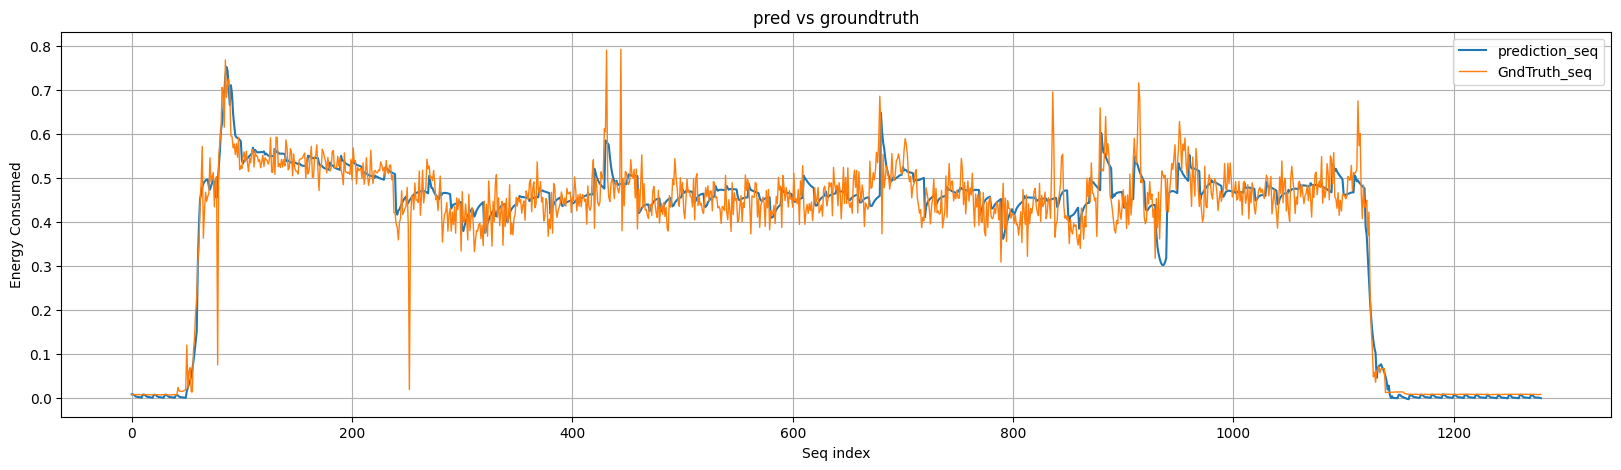

In [9]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'TCN_LSTM_select3_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
flight_num = 276 #random.randint(0, 100)
flight_num = random.choice(d_split['test'])
test_data = data[data['flight'] == flight_num]
input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                         test_data['power'].values,input_len,output_len)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    
    outputs = seq2seq(input_seq)  # No need for target length
    # Adjust the dimensions if necessary, based on your loss function requirements
    # Example: If your outputs and targets are both [batch_size, 2, 1]
    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    print(f"MAPE: {mape}")
    
    plot_output(outputs.cpu(), targets.cpu(), output_len)


In [10]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'TCN_LSTM_select3_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
mape_list = []
flights = d_split['test']
# flights.remove(273)
for flight_num in flights:
    # flight_num = 276 #random.randint(0, 100)
    test_data = data[(data['flight'] == flight_num) & (data['power'] > 0.05)]
    input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                            test_data['power'].values,input_len,output_len)

    input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
    output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)


    with torch.no_grad():
        
        outputs = seq2seq(input_seq)  # No need for target length
        # Adjust the dimensions if necessary, based on your loss function requirements
        # Example: If your outputs and targets are both [batch_size, 2, 1]
        outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
        targets = output_seq

        error = nn.MSELoss()(outputs, targets)
        # print(f"Test loss: {error}")

        mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
        # print(f"MAPE: {mape}")
        mape_list.append(mape)
        # plot_output(outputs.cpu(), targets.cpu(), output_len)

print(f"avg MAPE: {sum(mape_list)/len(mape_list)}")


avg MAPE: 8.834639549255371


In [11]:
from data_process import create_sequences
from utils import plot_output
import numpy as np

mape_list = []
for flight_num in flights:
    test_data = data[(data['flight'] == flight_num)]
    outputs = test_data['power'].mean()
    test_data = test_data[data['power'] > 0.05]

    # test_data.plot(x='time', y='power', figsize=(20, 5))

    
    targets = test_data['power'].values
    mape = np.mean(np.abs((outputs - targets) / targets)) * 100
    # print(f"MAPE: {mape}")
    mape_list.append(mape)

print(f"avg worst MAPE: {sum(mape_list)/len(mape_list)}")

avg worst MAPE: 28.041943203441367


In [12]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'TCN_LSTM_select3_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
test_nums = d_split['test']
sum_mape = 0
sum_size = 0
for f_num in d_split['test']:
    test_data = data[data['flight'] == f_num]
    input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                            test_data['power'].values,input_len,output_len)

    input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
    output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

    # print(f"Flight {f_num}:")

    with torch.no_grad():
        
        outputs = seq2seq(input_seq)  # No need for target length
        # Adjust the dimensions if necessary, based on your loss function requirements
        # Example: If your outputs and targets are both [batch_size, 2, 1]
        outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
        targets = output_seq
    
        # error = nn.MSELoss()(outputs, targets)
        # print(f"Test loss: {error}")

        mape = torch.sum(torch.abs((outputs - targets) / targets)) * 100
        sum_mape += mape
        sum_size += targets.shape[0]*targets.shape[1]

print(f"Test MAPE: {sum_mape/sum_size}")


Test MAPE: 25.558074951171875


In [13]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'TCN_LSTM_select3_best_model_{input_len}-{output_len}.pt'))

# test the model
seq2seq.eval()
mape_list = []
sum_mape = 0
sum_size = 0
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1)
        
    mape = torch.sum(torch.abs((outputs - targets) / targets)) * 100
    sum_mape += mape
    sum_size += targets.shape[0]*targets.shape[1]

print(f"Test MAPE: {sum_mape/sum_size}")


Test MAPE: 25.56399154663086


It seems LSTM-LSTM is better than current design of TCN-LSTM